In [115]:
from scripts import preprocessing_old
from scripts import predict_stromfluss
from scripts import preprocessing_weatherdata
from scripts import preprocessing_plannedProduction
from scripts import preprocessing_trade_price_consumption
from bda import bda_utilities
import pandas as pd
import numpy as np
import os.path

## Preprocessing

Load and format power flow.

In [71]:
df = predict_stromfluss.read_data_stromfluss('./data/stromfluss')
df = predict_stromfluss.preprocessing_stromfluss(df)

In [72]:
def create_net_columns(df):
    countries = ["NL", "CHE", "DNK", "CZE", "LUX", "SWE", "AUT", "FRA", "PL"]
    for country in countries:
        im_key = country + "_IM"
        ex_key = country + "_EX"
        df[country]=df[im_key] +df[ex_key]
        df = df.drop(columns=[im_key,ex_key])
    return df


In [73]:
df = create_net_columns(df)
df = df.rename(columns={"Date":"date"})
df.head()

,date,NX,NL,CHE,DNK,CZE,LUX,SWE,AUT,FRA,PL
0,2015-06-01 00:00:00,7279.0,3932.0,145.0,-272.0,554.0,0.0,1.0,1394.0,246.0,1279.0
1,2015-06-01 01:00:00,7167.0,4014.0,261.0,-141.0,469.0,0.0,1.0,1355.0,66.0,1142.0
2,2015-06-01 02:00:00,6667.0,3864.0,103.0,-326.0,422.0,0.0,1.0,1574.0,-105.0,1134.0
3,2015-06-01 03:00:00,6413.0,4242.0,42.0,-262.0,235.0,0.0,1.0,1271.0,-206.0,1090.0
4,2015-06-01 04:00:00,5347.0,4292.0,-127.0,-582.0,161.0,0.0,1.0,1068.0,-549.0,1083.0


Load and format weather data. 

In [74]:
df_weather = preprocessing_weatherdata.import_weatherData()
df_weather = df_weather[df_weather['date'].dt.year >= 2015]
df_weather.head()

,date,DE_av_windspeed_ms_north,DE_percip_mm_north,DE_sun_hrs_north,DE_av_windspeed_ms_south,DE_percip_mm_south,DE_sun_hrs_south,DK_sun_hrs,DK_av_windSpeed_ms,CZ_av_temperatureChange,CZ_av_windSpeed,FR_av_temperatureChange,FR_av_windSpeed
48942,2015-01-01,7.336364,-112.171429,2.980412,2.880556,0.065789,2.053026,0.0,8.4,NaN,NaN,NaN,NaN
48943,2015-01-02,10.930303,-112.431429,0.984794,5.925714,3.997368,0.451316,2.0,12.0,NaN,NaN,NaN,NaN
48944,2015-01-03,8.972727,-111.354286,0.045118,4.957143,14.647368,0.111895,2.5,8.2,NaN,NaN,NaN,NaN
48945,2015-01-04,7.393939,-113.365714,3.463676,4.774286,1.015789,1.045184,5.2,6.0,NaN,NaN,NaN,NaN
48946,2015-01-05,5.606061,-113.351429,0.894176,3.035294,0.168421,4.415789,0.3,3.2,NaN,NaN,NaN,NaN


In [75]:
#make hourly
df_weather = bda_utilities.make_hourly(df_weather)

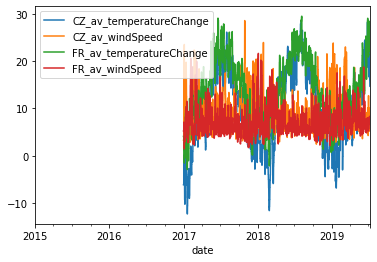

In [76]:
# Weather data for CZ and FR only start in 2017, so we drop them
df_weather.set_index("date").iloc[:,8:].plot()
df_weather = df_weather.drop(columns=df_weather.columns[8:])

In [77]:
# Percipitation has probably no effect on power flow, so we drop those as well 
df_weather = df_weather.drop(columns=[col for col in df_weather.columns if "percip" in col])

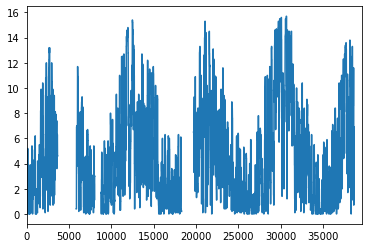

In [78]:
# DK sun hours has great portions of missing values, so we drop it . 
df_weather['DK_sun_hrs'].plot()
df_weather = df_weather.drop(columns=['DK_sun_hrs'])

Create a df containing a 24 lag for power flow values. 

In [79]:
df_24h_lag = df.copy()
df_24h_lag.set_index("date", inplace=True)
df_24h_lag = df_24h_lag.shift(+24)

def custom_column_mapper(df, append_str):
    cols = df.columns
    mapper = {}
    for col in cols:
        mapper[col]=col + append_str
    return mapper

df_24h_lag.rename(columns=custom_column_mapper(df_24h_lag, "-24h"), inplace=True)
df_24h_lag.reset_index(inplace=True)
df_24h_lag.iloc[20:28]

,date,NX-24h,NL-24h,CHE-24h,DNK-24h,CZE-24h,LUX-24h,SWE-24h,AUT-24h,FRA-24h,PL-24h
20,2015-06-01 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,2015-06-01 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2015-06-01 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,2015-06-01 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,2015-06-02 00:00:00,7279.0,3932.0,145.0,-272.0,554.0,0.0,1.0,1394.0,246.0,1279.0
25,2015-06-02 01:00:00,7167.0,4014.0,261.0,-141.0,469.0,0.0,1.0,1355.0,66.0,1142.0
26,2015-06-02 02:00:00,6667.0,3864.0,103.0,-326.0,422.0,0.0,1.0,1574.0,-105.0,1134.0
27,2015-06-02 03:00:00,6413.0,4242.0,42.0,-262.0,235.0,0.0,1.0,1271.0,-206.0,1090.0


Check other external information: trade, price, and consumption

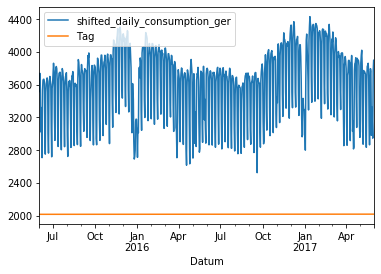

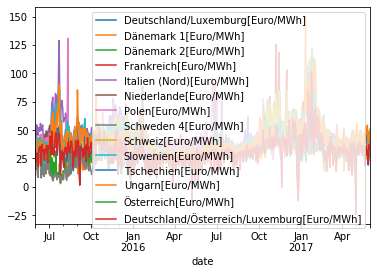

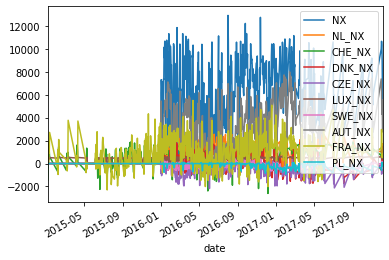

In [80]:
# All this data is only until 2017. Is there more recent data? 
# For now, don't include these in the master dataframe

df_consumption = preprocessing_trade_price_consumption.import_consumptionData()
df_consumption.plot()

df_price = preprocessing_trade_price_consumption.import_priceData()
df_price.set_index("date").plot()

df_trade = preprocessing_trade_price_consumption.import_foreignTradeData()
df_trade.set_index("date").plot()

Make master dataframe containing all the information. 

In [81]:
df_master = df.copy()
df_master = df_master.merge(df_24h_lag)
df_master = df_master.merge(df_weather)

# split up datetime information, keep date as index for easier manipulation
df_master.set_index(['date'], append=True, inplace=True, drop=False)
df_master = bda_utilities.split_datetime(df_master)


In [92]:
# move datetime columns to the front for readibility

# It is bugged, i don't know why 
def move_columns_to_front(df, front_column_names): 
    '''
    Returns a list with reordered column names 
    '''
    columns = list(df.columns)
    for col in front_column_names:
        if col not in columns:
            front_column_names.remove(col) 
    for col in columns:
        if col in front_column_names:
            columns.remove(col)
    result = front_column_names + columns
    return result

# Static hotfix
def move_columns_to_front_static(df, front_column_names):
    result = move_columns_to_front(df, front_column_names)
    result.pop(-1)
    result.pop(-1)
    return result
    

column_order = move_columns_to_front_static(df_master, front_column_names=["year","month","weekday","hour","timestamp"])
df_master = df_master.loc[:,column_order]

In [106]:
# Save to data 
df_master.to_csv("./data/df_master.csv")

In [108]:
df_test = pd.read_csv("./data/df_master.csv", index_col=[0,1])
df_test.head()

,,year,month,weekday,hour,timestamp,NX,NL,CHE,DNK,CZE,...,CZE-24h,LUX-24h,SWE-24h,AUT-24h,FRA-24h,PL-24h,DE_av_windspeed_ms_north,DE_sun_hrs_north,DE_av_windspeed_ms_south,DE_sun_hrs_south
,date,,,,,,,,,,,,,,,,,,,,,
0,2015-06-01 00:00:00,2015,6,1,0,1.433117e+09,7279.0,3932.0,145.0,-272.0,554.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.65,3.698263
1,2015-06-01 01:00:00,2015,6,1,1,1.433120e+09,7167.0,4014.0,261.0,-141.0,469.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.65,3.698263
2,2015-06-01 02:00:00,2015,6,1,2,1.433124e+09,6667.0,3864.0,103.0,-326.0,422.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.65,3.698263
3,2015-06-01 03:00:00,2015,6,1,3,1.433128e+09,6413.0,4242.0,42.0,-262.0,235.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.65,3.698263
4,2015-06-01 04:00:00,2015,6,1,4,1.433131e+09,5347.0,4292.0,-127.0,-582.0,161.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.65,3.698263


In [119]:
def load_master_df(path_to_master_df="./data/df_master.csv"):
    try:
        return pd.read_csv(path_to_master_df, index_col=[0, 1])
    except FileNotFoundError as e:
        print(e)

load_master_df()


,,year,month,weekday,hour,timestamp,NX,NL,CHE,DNK,CZE,...,CZE-24h,LUX-24h,SWE-24h,AUT-24h,FRA-24h,PL-24h,DE_av_windspeed_ms_north,DE_sun_hrs_north,DE_av_windspeed_ms_south,DE_sun_hrs_south
,date,,,,,,,,,,,,,,,,,,,,,
0,2015-06-01 00:00:00,2015,6,1,0,1.433117e+09,7279.0,3932.0,145.0,-272.0,554.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.650000,3.698263
1,2015-06-01 01:00:00,2015,6,1,1,1.433120e+09,7167.0,4014.0,261.0,-141.0,469.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.650000,3.698263
2,2015-06-01 02:00:00,2015,6,1,2,1.433124e+09,6667.0,3864.0,103.0,-326.0,422.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.650000,3.698263
3,2015-06-01 03:00:00,2015,6,1,3,1.433128e+09,6413.0,4242.0,42.0,-262.0,235.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.650000,3.698263
4,2015-06-01 04:00:00,2015,6,1,4,1.433131e+09,5347.0,4292.0,-127.0,-582.0,161.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.650000,3.698263
5,2015-06-01 05:00:00,2015,6,1,5,1.433135e+09,4095.0,3993.0,-494.0,-626.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.650000,3.698263
6,2015-06-01 06:00:00,2015,6,1,6,1.433138e+09,1940.0,3330.0,-1243.0,-826.0,449.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.650000,3.698263
7,2015-06-01 07:00:00,2015,6,1,7,1.433142e+09,384.0,3010.0,-1622.0,-732.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.650000,3.698263
8,2015-06-01 08:00:00,2015,6,1,8,1.433146e+09,841.0,3389.0,-1652.0,-562.0,-401.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.650000,3.698263
